In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.set_cmap('viridis')
import scipy.io as sio
import time
import sys
sys.path.append('/home/matsui-k/projects/d-rcn')
from scripts.core import TN_utils, models, compiling, optimizers, blocks
reload(TN_utils)
reload(models)
reload(blocks)

Using gpu device 1: Tesla K40m (CNMeM is disabled, CuDNN not available)
WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. /home/matsui-k/.theano/compiledir_Linux-3.13--generic-x86_64-with-debian-jessie-sid-x86_64-2.7.11-64/tmpzI6Lv4/key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '53650' (I am process '56284')


<module 'scripts.core.blocks' from '/home/matsui-k/projects/d-rcn/scripts/core/blocks.pyc'>

In [2]:
import theano
import theano.tensor as T

In [12]:
data_list = []
for order in [0, 1, 2]:
    fe, gt, mask, vol_shape = TN_utils.load_hardi(order)
    data, norm, gt_norm = TN_utils.preprocess(fe, gt, mask)
    data_list.append(data[0][:1000])
for data in data_list:
    print data.shape
D0 = TN_utils.wignerD(0)
D2 = TN_utils.wignerD(2)
D4 = TN_utils.wignerD(4)

(430080, 31, 1) (430080, 1) (430080,)
(21485, 1, 31)
(21485, 1)
(5372, 1, 31)
(5372, 1)
(430080, 43, 10) (430080, 10) (430080,)
(21485, 10, 43)
(21485, 10)
(5372, 10, 43)
(5372, 10)
(430080, 37, 18) (430080, 18) (430080,)
(21485, 18, 37)
(21485, 18)
(5372, 18, 37)
(5372, 18)
(1000, 1, 31)
(1000, 10, 43)
(1000, 18, 37)


[(0, 0), (2, 2), (4, 4)]
(0, 0)
(2, 2)
(4, 4)
[W_0_(0, 0), W_0_(0, 0), W_2_(2, 2), W_2_(2, 2), W_4_(4, 4), W_4_(4, 4)] [bias_(0, 0), bias_(2, 2), bias_(4, 4)]


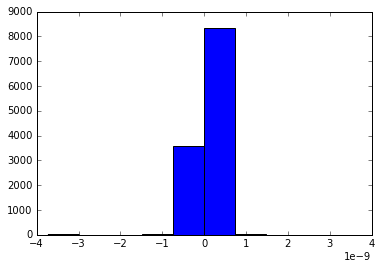

In [13]:
j_input_list = [0, 2, 4]
j_output = 0
tensor_list = [T.tensor3() for i in range(len(j_input_list))]
n_input_tensors_list = [31, 43, 37]
n_output_tensors = 2

out, weight_list, bias_list, n_couples = blocks.multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list,
                                                                n_output_tensors, is_train=True)

f = theano.function(inputs=tensor_list,
                    outputs=[out])

a = f(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), data_list[1], data_list[2])[0]
b = f(TN_utils.rotate_tensor(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), D0), 
        TN_utils.rotate_tensor(data_list[1], D2),
      TN_utils.rotate_tensor(data_list[2], D4))[0]

plt.hist((b - TN_utils.rotate_tensor(a, D0)).flatten())
print weight_list, bias_list

[(0, 2), (2, 2), (2, 4), (4, 4)]
(0, 2)
(2, 2)
(2, 4)
(4, 4)
[W_0_(0, 2), W_2_(0, 2), W_2_(2, 2), W_2_(2, 2), W_2_(2, 4), W_4_(2, 4), W_4_(4, 4), W_4_(4, 4)] [bias_(0, 2), bias_(2, 2), bias_(2, 4), bias_(4, 4)]


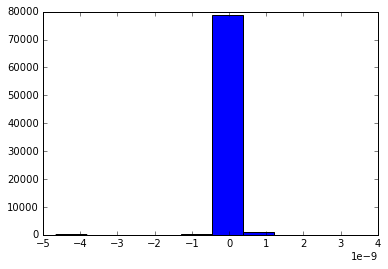

In [14]:
j_input_list = [0, 2, 4]
j_output = 2
tensor_list = [T.tensor3() for i in range(len(j_input_list))]
n_input_tensors_list = [31, 43, 37]
n_output_tensors = 2

out, weight_list, bias_list, n_couples = blocks.multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list, 
                                                                n_output_tensors, is_train=True)

f = theano.function(inputs=tensor_list,
                    outputs=[out])

a = f(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), data_list[1], data_list[2])[0]
b = f(TN_utils.rotate_tensor(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), D0), 
        TN_utils.rotate_tensor(data_list[1], D2),
      TN_utils.rotate_tensor(data_list[2], D4))[0]

plt.hist((b - TN_utils.rotate_tensor(a, D2)).flatten())
print weight_list, bias_list

[(0, 4), (2, 2), (2, 4), (4, 4)]
(0, 4)
(2, 2)
(2, 4)
(4, 4)


(array([  2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          7.00000000e+01,   5.67000000e+03,   1.38023000e+05,
          2.00000000e+02,   2.70000000e+01,   4.00000000e+00,
          2.00000000e+00]),
 array([ -4.65661287e-09,  -3.76021490e-09,  -2.86381692e-09,
         -1.96741894e-09,  -1.07102096e-09,  -1.74622983e-10,
          7.21774995e-10,   1.61817297e-09,   2.51457095e-09,
          3.41096893e-09,   4.30736691e-09]),
 <a list of 10 Patch objects>)

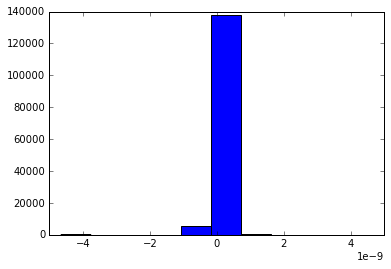

In [15]:
j_input_list = [0, 2, 4]
j_output = 4
tensor_list = [T.tensor3() for i in range(len(j_input_list))]
n_input_tensors_list = [31, 43, 37]
n_output_tensors = 2

out, weight_list, bias_list, n_couples = blocks.multi_order_mix(tensor_list, j_input_list, j_output, n_input_tensors_list,
                                                         n_output_tensors, is_train=True)

f = theano.function(
                    inputs=tensor_list,
                    outputs=[out])

a = f(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), data_list[1], data_list[2])[0]
b = f(TN_utils.rotate_tensor(np.concatenate([data_list[0], np.zeros_like(data_list[0])], axis=1), D0), 
        TN_utils.rotate_tensor(data_list[1], D2),
      TN_utils.rotate_tensor(data_list[2], D4))[0]

plt.hist((b - TN_utils.rotate_tensor(a, D4)).flatten())